In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import keras.backend as K
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 32
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## Inception

In [2]:
#transfer learning
from keras.applications.inception_v3 import InceptionV3

In [3]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

for layer in base_model.layers:
    layer.trainable=False

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 batch_normalization_94 (Bat  (None, 6, 6, 2048)       8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 23,915,302
Trainable params: 2,108,422
Non

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
import time
# Record the start time of training
start_time = time.time()

In [10]:
epochs = 10
import keras

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='inception_model_32batchsize.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]

#Training
inception_history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // 32,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // 32)

Epoch 1/10


2024-04-19 21:39:56.565707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-19 21:39:58.888734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-19 21:39:58.892129: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1c8ccb00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-19 21:39:58.892185: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-19 21:39:58.903632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-19 21:39:59.061346: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

52/52 [==============================] - ETA: 0s - loss: 1.3288 - accuracy: 0.4860
Epoch 1: val_loss improved from inf to 1.62776, saving model to inception_model_32batchsize.h5


/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 55s 892ms/step - loss: 1.3288 - accuracy: 0.4860 - val_loss: 1.6278 - val_accuracy: 0.4303
Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 0.8047 - accuracy: 0.7118
Epoch 2: val_loss improved from 1.62776 to 0.99900, saving model to inception_model_32batchsize.h5
52/52 [==============================] - 46s 886ms/step - loss: 0.8047 - accuracy: 0.7118 - val_loss: 0.9990 - val_accuracy: 0.6226
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.7931
Epoch 3: val_loss improved from 0.99900 to 0.93102, saving model to inception_model_32batchsize.h5
52/52 [==============================] - 43s 829ms/step - loss: 0.5952 - accuracy: 0.7931 - val_loss: 0.9310 - val_accuracy: 0.6394
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.8453
Epoch 4: val_loss improved from 0.93102 to 0.53966, saving model to inception_model_32batchsize.h5
52/52 [==================

In [11]:
# Record the training end time
end_time = time.time()

In [12]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 557.804360628128 seconds


In [13]:
pd.DataFrame(inception_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.328847,0.486044,1.627757,0.430288
1,0.804714,0.711772,0.999003,0.622596
2,0.595225,0.793083,0.931019,0.639423
3,0.468285,0.845267,0.539657,0.822115
4,0.426635,0.858617,0.639257,0.771635
5,0.352171,0.893204,0.686639,0.776442
6,0.366087,0.874393,1.209986,0.596154
7,0.360968,0.865291,0.605436,0.769231
8,0.303327,0.893204,0.473559,0.826923
9,0.275904,0.902306,0.693021,0.774038


In [14]:
import joblib
joblib.dump(inception_history.history,'history_Inception_DA_32batchsize.pkl')
inception_history = joblib.load('history_Inception_DA_32batchsize.pkl')

In [15]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.tight_layout()

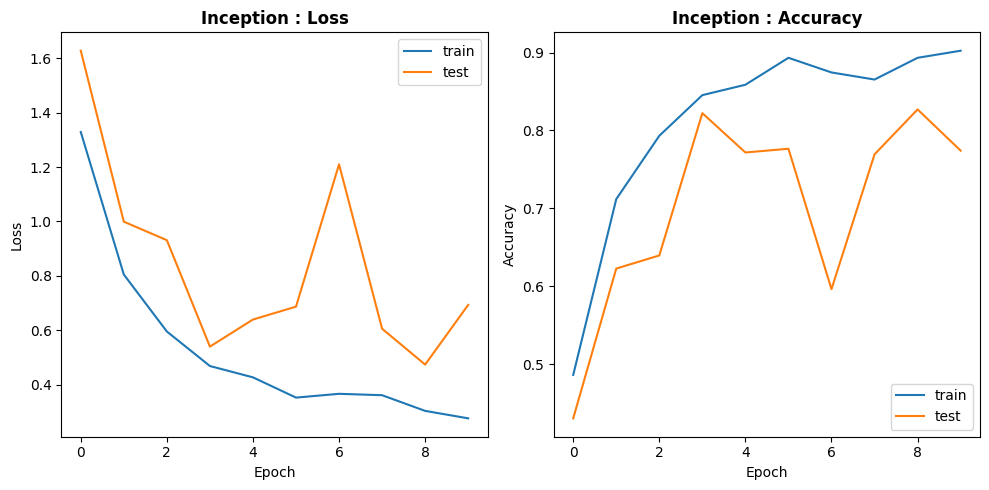

In [16]:
plot_performance(model_name='Inception',
                acc=inception_history['accuracy'], 
                 val_acc=inception_history['val_accuracy'],
                 loss=inception_history['loss'], 
                 val_loss=inception_history['val_loss'])

In [17]:
# Load the best saved model
from keras.models import load_model

model_3 = load_model('inception_model_32batchsize.h5')
score = model_3.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model_3.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

14/14 [==============================] - 11s 741ms/step - loss: 0.4215 - accuracy: 0.8357

Val loss: 0.4215313196182251
Val accuracy: 0.8357142806053162
17/17 [==============================] - 12s 716ms/step - loss: 0.3474 - accuracy: 0.8864

Test loss: 0.3473775088787079
Test accuracy: 0.8863636255264282


In [18]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

17/17 [==============================] - 12s 648ms/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.88      0.93        88
           brown_spot       0.77      0.86      0.81        88
              healthy       0.89      0.90      0.89        88
           leaf_blast       0.78      0.70      0.74        88
           leaf_scald       0.88      0.93      0.91        88
    narrow_brown_spot       0.91      0.94      0.93        88

             accuracy                           0.87       528
            macro avg       0.87      0.87      0.87       528
         weighted avg       0.87      0.87      0.87       528



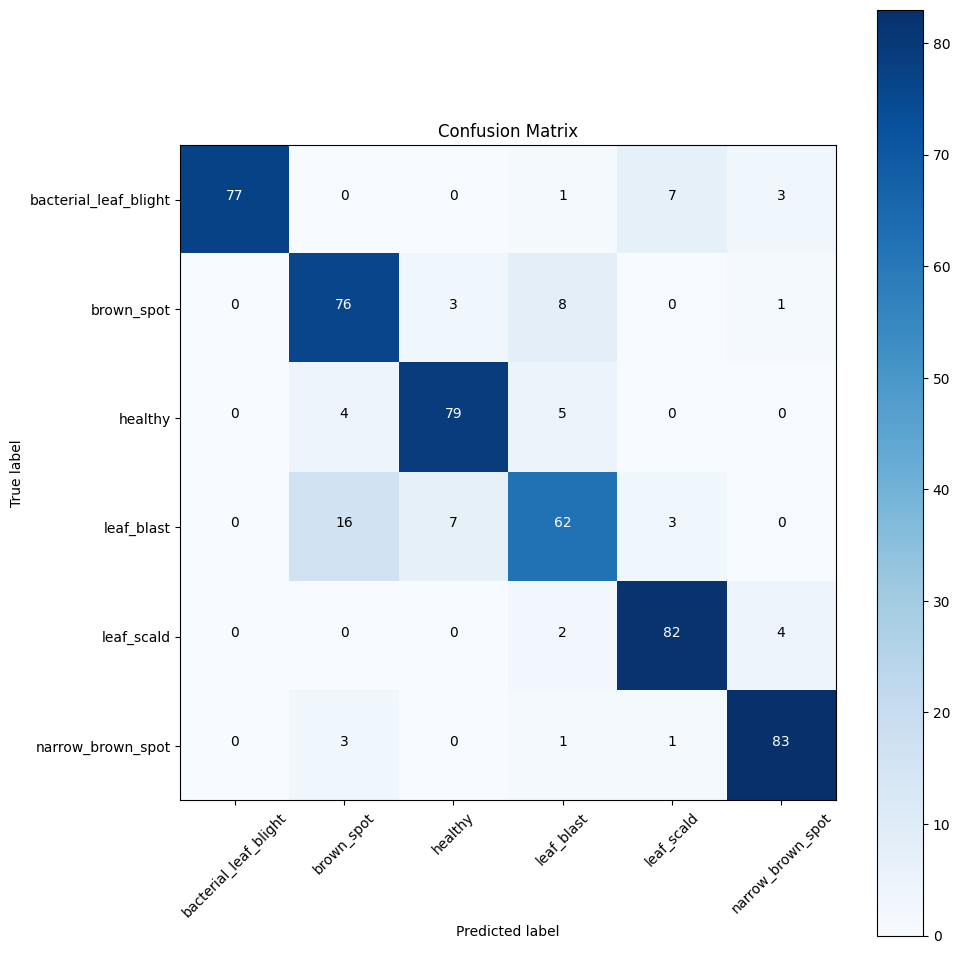

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model_3.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))


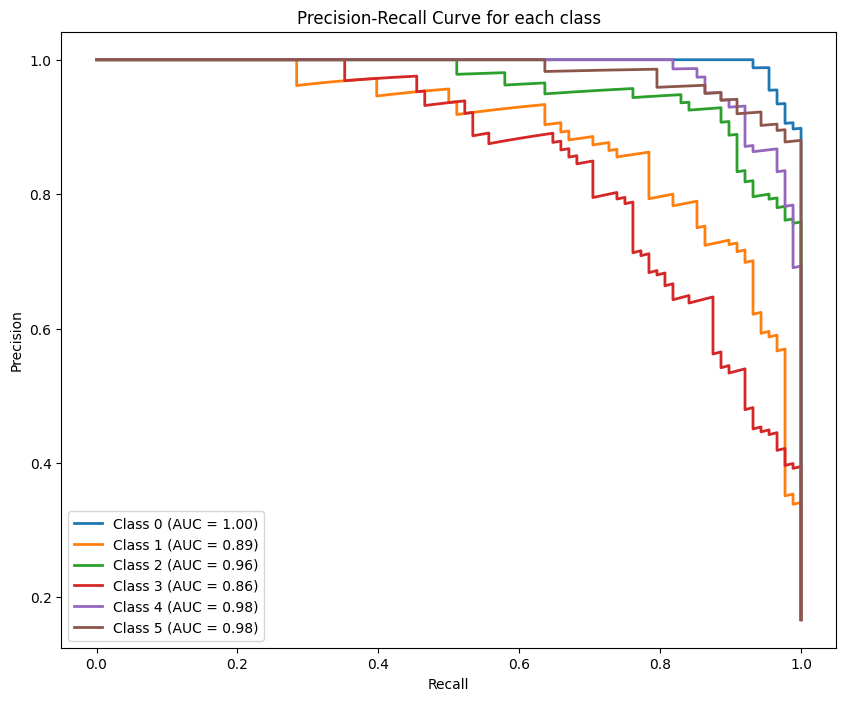

In [20]:
# Precision-Recall Curve for each class
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])
    
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend(loc="best")
plt.show()

In [21]:
#Generate predictions for the test dataset
y_pred = model_3.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

17/17 [==============================] - 12s 699ms/step


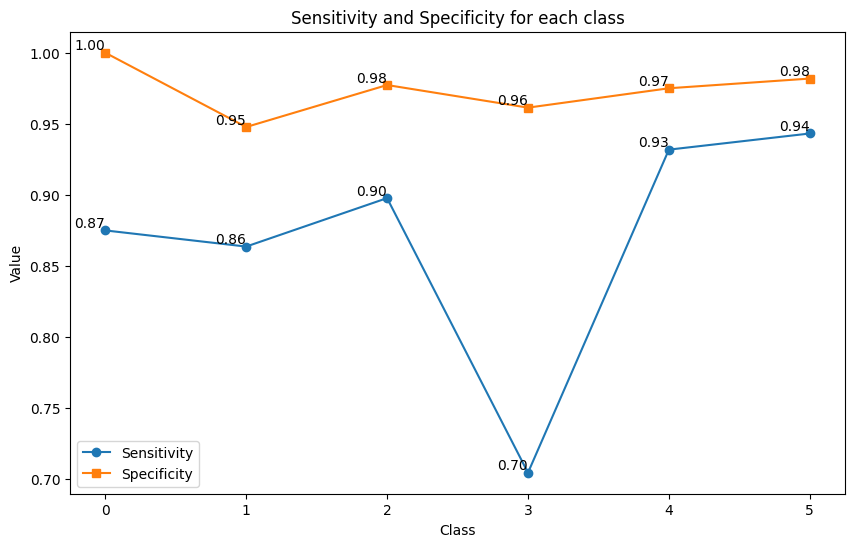

In [22]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Plot Sensitivity and Specificity for each class
plt.figure(figsize=(10, 6))
plt.plot(range(len(sensitivity_list)), sensitivity_list, marker='o', label='Sensitivity')
plt.plot(range(len(specificity_list)), specificity_list, marker='s', label='Specificity')
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('Sensitivity and Specificity for each class')
plt.legend()

# Add numeric labels
for i, (sensitivity, specificity) in enumerate(zip(sensitivity_list, specificity_list)):
    plt.text(i, sensitivity, f'{sensitivity:.2f}', ha='right', va='bottom')
    plt.text(i, specificity, f'{specificity:.2f}', ha='right', va='bottom')

plt.show()

In [23]:
print(sensitivity_list)
print(specificity_list)

[0.8749999999990057, 0.8636363636353822, 0.8977272727262525, 0.7045454545446539, 0.931818181817123, 0.9431818181807463]
[0.9999999999997727, 0.9477272727270574, 0.9772727272725052, 0.9613636363634179, 0.9749999999997785, 0.9818181818179587]


In [24]:
# Evaluate the performance of the model
evaluate = model_3.evaluate(
    test_generator, 
    steps = test_generator.n // BATCH_SIZE, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

16/16 [==============================] - 11s 718ms/step - loss: 0.3508 - accuracy: 0.8730
Accuracy Test : 0.873046875
